(The following code is written in python 2)

In [0]:
#!/usr/bin/python2
from __future__ import division

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression


# downloading dataset

!wget -O "LA Traffic_Collision_Data_from_2010_to_Present.csv" https://data.lacity.org/api/views/d5tf-ez2w/rows.csv?accessType=DOWNLOAD
  
!wget -O "Chicago 2012 CrashExtract.zip" http://chicagocrashes.s3.amazonaws.com/crashdata/illinois_2012/StatewideExtract2012.zip
!wget -O "Chicago 2013 CrashExtract.zip" http://s3.amazonaws.com/chicagocrashes/crashdata/illinois_2013/2013_CrashExtract.txt.zip
!wget -O "Chicago 2014 CrashExtract.zip" http://s3.amazonaws.com/chicagocrashes/crashdata/illinois_2014/2014_IllinoisCrashExtract.txt.zip
!wget -O "Chicago 2015 CrashExtract.zip" http://chicagocrashes.s3.amazonaws.com/crashdata/chicago_2015/2015_ChicagoCrashExtract.txt.zip

!unzip "Chicago 2012 CrashExtract.zip"
!mv CrashExtract.txt "Chicago 2012 CrashExtract.csv"
!unzip "Chicago 2013 CrashExtract.zip"
!mv CrashExtract.txt "Chicago 2013 CrashExtract.csv"
!unzip "Chicago 2014 CrashExtract.zip"
!mv CrashExtract.txt "Chicago 2014 CrashExtract.csv"
!unzip "Chicago 2015 CrashExtract.zip"
!mv CrashExtract.txt "Chicago 2015 CrashExtract.csv"

### !!!!!! ###
# Weather data website has been shut down, if you want to run everything, you must add the following csv data at the end of the notebook

Archive:  Chicago 2012 CrashExtract.zip
replace VehicleExtract.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: VehicleExtract.txt      
  inflating: CrashExtract.txt        
  inflating: PersonExtract.txt       
Archive:  Chicago 2013 CrashExtract.zip
  inflating: CrashExtract.txt        
replace __MACOSX/._CrashExtract.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._CrashExtract.txt  
Archive:  Chicago 2014 CrashExtract.zip
  inflating: CrashExtract.txt        
replace __MACOSX/._CrashExtract.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._CrashExtract.txt  
Archive:  Chicago 2015 CrashExtract.zip
  inflating: CrashExtract.txt        
replace __MACOSX/._CrashExtract.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._CrashExtract.txt  


In [0]:
!cp '/LA Traffic_Collision_Data_from_2010_to_Present.csv' ./

### saving data for LA

We parse two separate CSV files, one for weather data, and one for traffic accidents for the given city.

For LA, we calculate each day's number of accidents, the average temperature, and the precipitation in mm.

We then store this data into a new CSV with only the data we need to preform our analysis on.

In [0]:
def save_LA_data():
    daily_weather = pd.read_csv("LA Chi Daily Weather Temp Max Min Precip.csv")
    daily_weather['Date'] = pd.to_datetime(daily_weather['Date'])
    la_accidents = pd.read_csv("LA Traffic_Collision_Data_from_2010_to_Present.csv")
    la_accidents['Date Occurred'] = pd.to_datetime(la_accidents['Date Occurred'])

    #specify date range
    date_range = ['{dt.year}-{dt.month}-{dt.day}'.format(dt = d) for d in pd.date_range(start='1/1/2012', end='10/10/2015', freq='D').date]
    
    #make new lists for columns
    num_accidents = []
    avg_temps = []
    precip = []
  
    for date in date_range:
        #get number or accidents per day
        num_accidents_onday = len(la_accidents.loc[la_accidents['Date Occurred'] == date].index)
        num_accidents.append(num_accidents_onday)
        #get weather on day
        weather = daily_weather.loc[daily_weather['Date'] == date]
        #calc average temp
        avg_temps.append((float(weather.iloc[0]["Los Angeles; Temperature (max)"])+float(weather.iloc[0]["Los Angeles; Temperature (min)"]))/2.0)
        #get precipitation amount
        precip.append(float(weather.iloc[0]["Los Angeles; Precipitation"]))

    #create and save new dataframe
    la_data = pd.DataFrame(data={'Date':date_range, 'num_accidents': num_accidents, 'avg_temp': avg_temps, 'precipitation': precip})
    la_data.to_csv('LA_2012-2015_data.csv')

save_LA_data()

### saving data for Chicago

Same concept as the LA data, but we had separate CSV files for each year's accidents in chicago, so we had to consolidate them.

For Chicago, our accident data also contains road conditions of each accident. Additionally we include the number of reported accidents that occur on wet roads and the number of reported accidents that occur on snowy or slushy roads. These reports are slightly inconsistent because it is up to the police to decide to include this data or not.

In [0]:
def save_CHI_data():
    daily_weather = pd.read_csv("LA Chi Daily Weather Temp Max Min Precip.csv")
    daily_weather['Date'] = pd.to_datetime(daily_weather['Date'])
    
    #combine all dataframes in a list
    chi_accidents2012 = pd.read_csv("Chicago 2012 CrashExtract.csv", parse_dates=True, error_bad_lines=False)
    chi_accidents2013 = pd.read_csv("Chicago 2013 CrashExtract.csv", parse_dates=True, error_bad_lines=False)
    chi_accidents2014 = pd.read_csv("Chicago 2014 CrashExtract.csv", parse_dates=True, error_bad_lines=False)
    chi_accidents2015 = pd.read_csv("Chicago 2015 CrashExtract.csv", parse_dates=True, error_bad_lines=False)
    chi_accidents = []
    chi_accidents.append(chi_accidents2012)
    chi_accidents.append(chi_accidents2013)
    chi_accidents.append(chi_accidents2014)
    chi_accidents.append(chi_accidents2015)
    
    #define date range
    date_range = ['{dt.month}/{dt.day}/{dt.year}'.format(dt = d) for d in pd.date_range(start='1/20/2012', end='10/10/2015', freq='D').date]
    
    #make new lists for columns
    num_accidents = []
    avg_temps = []
    precip = []
    num_accidents_rain = []
    num_accidents_snow = []
    for date in date_range:
        #get num accidents per type per day
        num_accidents_onday = 0
        num_accidents_onday_rain = 0
        num_accidents_onday_snow = 0
        for a in chi_accidents:
            chi = pd.DataFrame(a.loc[a.iloc[:,51] == 'Chicago'])
            num_accidents_onday += len(chi.loc[chi.iloc[:,37] == date].index)
            num_accidents_onday_rain += len(chi[(chi.iloc[:,37] == date) & (chi.iloc[:,62] == 'Rain')].index)
            num_accidents_onday_snow += len(chi[(chi.iloc[:,37] == date) & (chi.iloc[:,62] == 'Snow')].index)

        num_accidents.append(num_accidents_onday)
        num_accidents_rain.append(num_accidents_onday_rain)
        num_accidents_snow.append(num_accidents_onday_snow)

        #get weather on day 
        weather = daily_weather.loc[daily_weather['Date'] == date]

        #calc average temperature, temperature in data is unsigned
        if float(weather.iloc[0]["Chicago; Temperature (max)"]) > float(weather.iloc[0]["Chicago; Temperature (min)"]):
            avg_temps.append((float(weather.iloc[0]["Chicago; Temperature (max)"])+float(weather.iloc[0]["Chicago; Temperature (min)"]))/2.0)
        else:
            avg_temps.append((float(weather.iloc[0]["Chicago; Temperature (max)"])-float(weather.iloc[0]["Chicago; Temperature (min)"]))/2.0)
        
        #get amount of precipitation
        precip.append(float(weather.iloc[0]["Chicago; Precipitation"]))
    #define and save new dataframe
    chi_data = pd.DataFrame(data={'Date':date_range, 'num_accidents': num_accidents, 'num_accidents_rain': num_accidents_rain, 'num_accidents_snow': num_accidents_snow, 'avg_temp': avg_temps, 'precipitation': precip})
    chi_data.to_csv('chi_2012-2015_data.csv')
    
save_CHI_data()

#### LA time series graph

contains number of accidents, running average number of accidents, the average temperature, precipitation in mm on each day with precipitation > 0mm

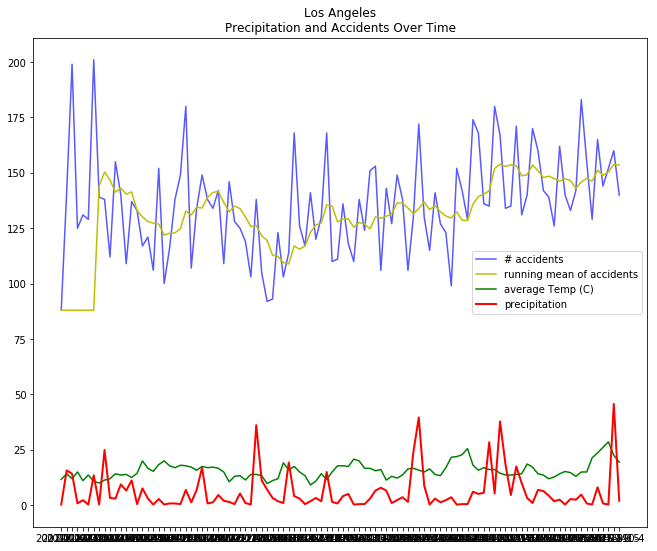

In [0]:
def plot_LA_data():
    data = pd.read_csv("LA_2012-2015_data.csv")
    #only look at days with precipitation
    data = data.loc[data['precipitation'] > 0]
    plt.figure(figsize=(11,9))
    
    # calculate moving average
    N = 8
    ma_accidents = np.convolve(list(data['num_accidents']), np.ones((N,))/N, mode='valid')
    for i in range(N-1):
        ma_accidents = np.insert(ma_accidents, 0, list(data['num_accidents'])[0])


    plt.title('Los Angeles\nPrecipitation and Accidents Over Time')
    plt.plot(data['Date'], data['num_accidents'], 'b', label='# accidents', alpha=0.65)
    plt.plot(data['Date'], ma_accidents, 'y', label='running mean of accidents')
    plt.plot(data['Date'], data['avg_temp'], 'g', label='average Temp (C)')
    plt.plot(data['Date'], data['precipitation'], 'r', label='precipitation',linewidth=2.0)
    plt.legend()
    plt.show()

plot_LA_data()

#### Scatter plot for LA.

number of accidents on day vs. precipitation amount

contains linear regression of the data points

Coefficient:  [[0.78912876]]
Intercept:  [130.89231808]


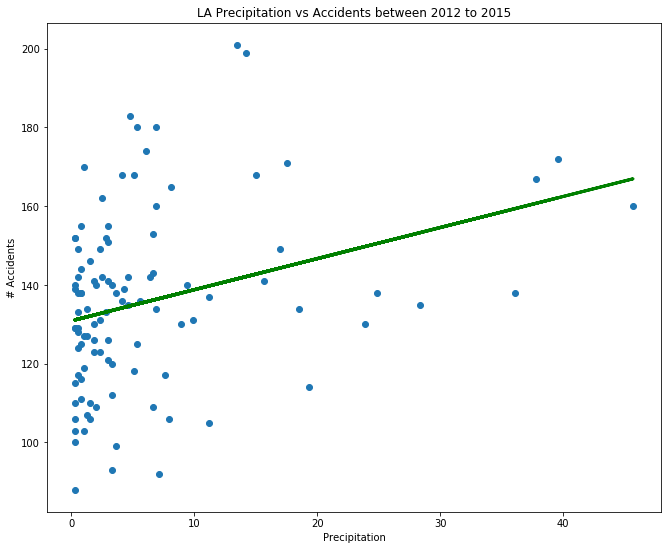

In [0]:
def la_scatter():
    data = pd.read_csv("LA_2012-2015_data.csv
    #only look at days with precipitation
    data = data.loc[data['precipitation'] > 0]
    plt.figure(figsize=(11,9))
    X = pd.DataFrame(data['precipitation'])
    Y = pd.DataFrame(data['num_accidents'])
    
    model = LinearRegression()
    model.fit(X, Y)
    line = model.predict(X)

    print 'Coefficient: ', model.coef_
    print 'Intercept: ', model.intercept_

    plt.scatter(data['precipitation'], data['num_accidents'])
    plt.plot(data['precipitation'], line, color='green', linewidth=3)
    plt.title('LA Precipitation vs Accidents between 2012 to 2015')
    plt.xlabel('Precipitation')
    plt.ylabel('# Accidents')
    plt.show()
    
la_scatter()


#### Temperature Scatter plot for LA.

number of accidents on day vs. average temperature in celcius

contains linear regression of the data points

Coefficient:  [[1.18645176]]
Intercept:  [107.17737603]


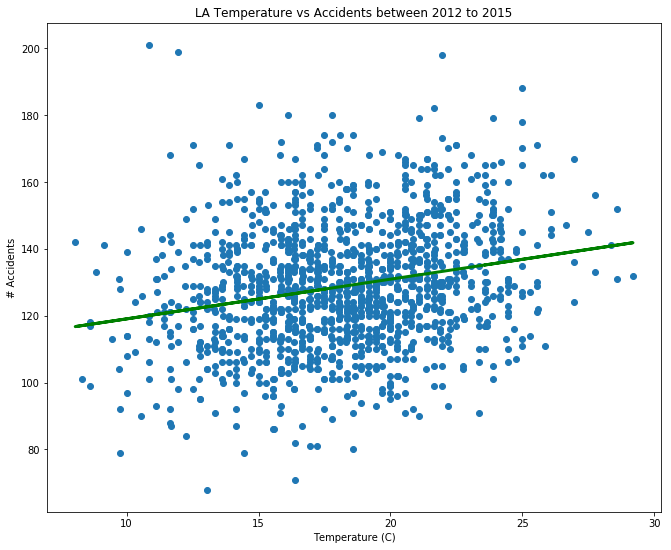

In [0]:
def la_scatter_temp():
    data = pd.read_csv("LA_2012-2015_data.csv")
    data = data.dropna()
    plt.figure(figsize=(11,9))
    
    X = pd.DataFrame(data['avg_temp'])
    Y = pd.DataFrame(data['num_accidents'])
    
    model = LinearRegression()
    reg = model.fit(X, Y)
    line = model.predict(X)
    
    print 'Coefficient: ', model.coef_
    print 'Intercept: ', model.intercept_
    plt.scatter(data['avg_temp'], data['num_accidents'])
    plt.plot(data['avg_temp'], line, color='green', linewidth=3)
    plt.title('LA Temperature vs Accidents between 2012 to 2015')
    plt.xlabel('Temperature (C)')
    plt.ylabel('# Accidents')
    plt.show()
    
    
la_scatter_temp()

#### Bar graph for LA

shows average number or accidents that have occurred with and without precipitation

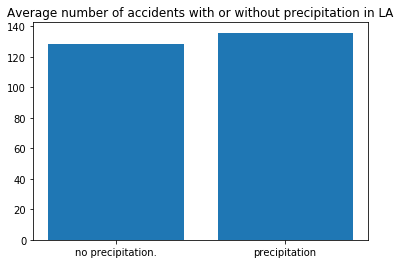

In [0]:
def avg_la():
    data = pd.read_csv("LA_2012-2015_data.csv")
    no_rain = data.loc[data['precipitation'] == 0]
    rain = data.loc[data['precipitation'] > 0]

    num_no_rain = len(no_rain.index)
    num_rain = len(rain.index)

    accidents_no_rain = no_rain.sum(axis=0)['num_accidents']
    accidents_rain = rain.sum(axis=0)['num_accidents']

    avg_no_rain = accidents_no_rain / num_no_rain
    avg_rain = accidents_rain / num_rain
    plt.title('Average number of accidents with or without precipitation in LA')
    plt.bar(['no precipitation.', 'precipitation'], [avg_no_rain, avg_rain])
    plt.show()

avg_la()


#### Chicago time series graph

contains number of accidents, running average number of accidents, the average temperature, precipitation in mm on each day with precipitation > 0mm

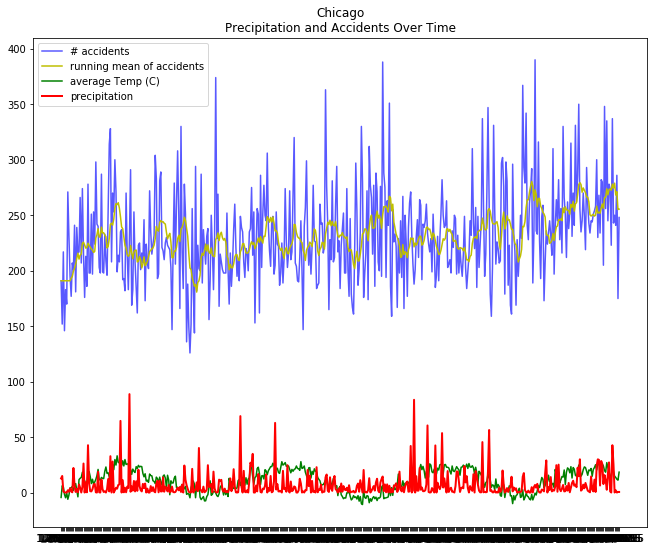

In [0]:
def plot_CHI_data():
    data = pd.read_csv("chi_2012-2015_data.csv")
    #only look at days with precipitation
    data = data.loc[data['precipitation'] > 0]
    plt.figure(figsize=(11,9))
    
    # calculate moving average
    N = 10
    ma_accidents = np.convolve(list(data['num_accidents']), np.ones((N,))/N, mode='valid')
    for i in range(N-1):
        ma_accidents = np.insert(ma_accidents, 0, list(data['num_accidents'])[0])


    plt.title('Chicago\nPrecipitation and Accidents Over Time')
    plt.plot(data['Date'], data['num_accidents'],'b', label='# accidents',alpha=0.65)
    plt.plot(data['Date'], ma_accidents, 'y', label='running mean of accidents')
    plt.plot(data['Date'], data['avg_temp'], 'g', label='average Temp (C)')
    plt.plot(data['Date'], data['precipitation'], 'r', label='precipitation',linewidth=2.0)
    plt.legend()
    plt.show()
    
plot_CHI_data()

#### Scatter plot for Chicago.

number of accidents on day vs. precipitation amount

contains linear regression of the data points

Coefficient:  [[0.49050149]]
Intercept:  [228.58332798]


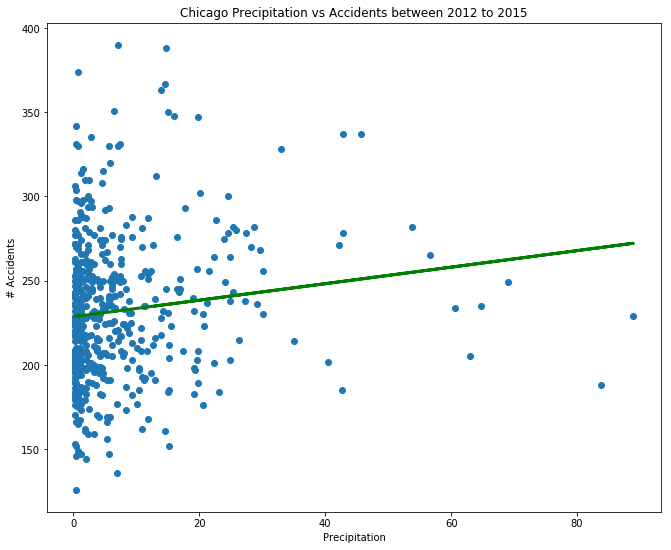

In [0]:
def chi_scatter():
    data = pd.read_csv("chi_2012-2015_data.csv")
    #only look at days with precipitation
    data = data.loc[data['precipitation'] > 0]
    plt.figure(figsize=(11,9))
    
    X = pd.DataFrame(data['precipitation'])
    Y = pd.DataFrame(data['num_accidents'])
    
    model = LinearRegression()
    reg = model.fit(X, Y)
    line = model.predict(X)
    
    print 'Coefficient: ', model.coef_
    print 'Intercept: ', model.intercept_
    plt.scatter(data['precipitation'], data['num_accidents'])
    plt.plot(data['precipitation'], line, color='green', linewidth=3)
    plt.title('Chicago Precipitation vs Accidents between 2012 to 2015')
    plt.xlabel('Precipitation')
    plt.ylabel('# Accidents')
    plt.show()
    
chi_scatter()


#### Temperature Scatter plot for Chicago.

number of accidents on day vs. average temperature in celcius

contains linear regression of the data points

Coefficient:  [[0.47400435]]
Intercept:  [219.92689519]


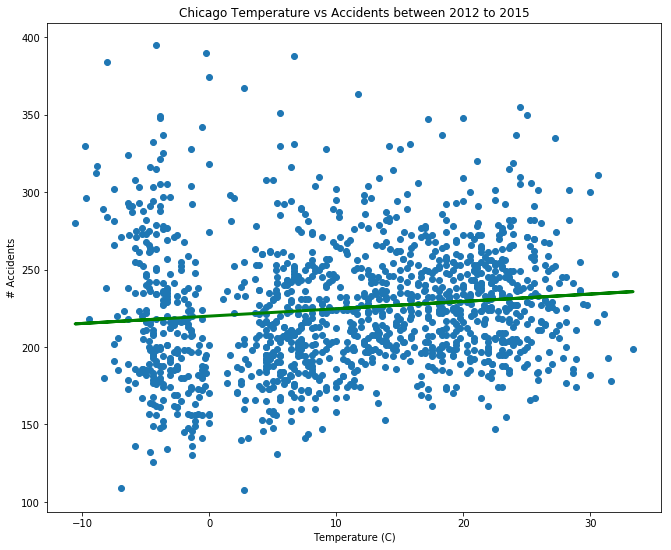

In [0]:
def chi_scatter_temp():
    data = pd.read_csv("chi_2012-2015_data.csv")
    data = data.dropna()
    plt.figure(figsize=(11,9))
    
    X = pd.DataFrame(data['avg_temp'])
    Y = pd.DataFrame(data['num_accidents'])
    
    model = LinearRegression()
    reg = model.fit(X, Y)
    line = model.predict(X)
    
    print 'Coefficient: ', model.coef_
    print 'Intercept: ', model.intercept_
    plt.scatter(data['avg_temp'], data['num_accidents'])
    plt.plot(data['avg_temp'], line, color='green', linewidth=3)
    plt.title('Chicago Temperature vs Accidents between 2012 to 2015')
    plt.xlabel('Temperature (C)')
    plt.ylabel('# Accidents')
    plt.show()
    
chi_scatter_temp()

#### rainy and snowy road condition scatter plots for Chicago

Same as previous precipitation scatter plots, but now we only consider the accidents for reported rainy and snowy road conditions 

contains linear regression of the data points

Coefficient:  [[0.95675943]]
Intercept:  [31.18065561]


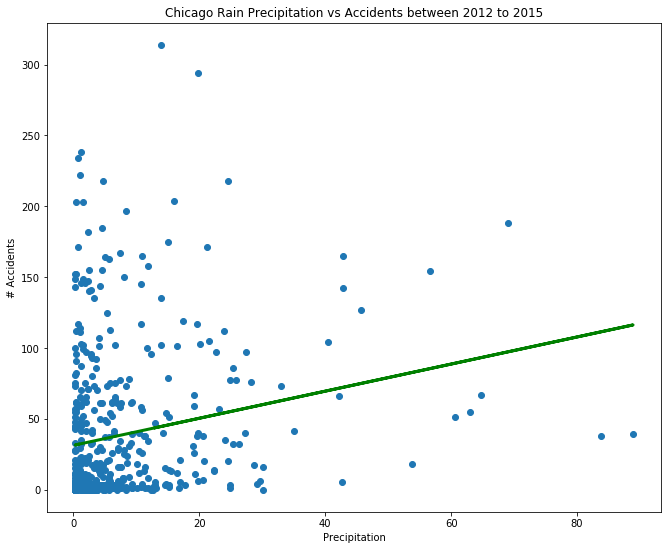

Coefficient:  [[-0.12003612]]
Intercept:  [17.49035995]


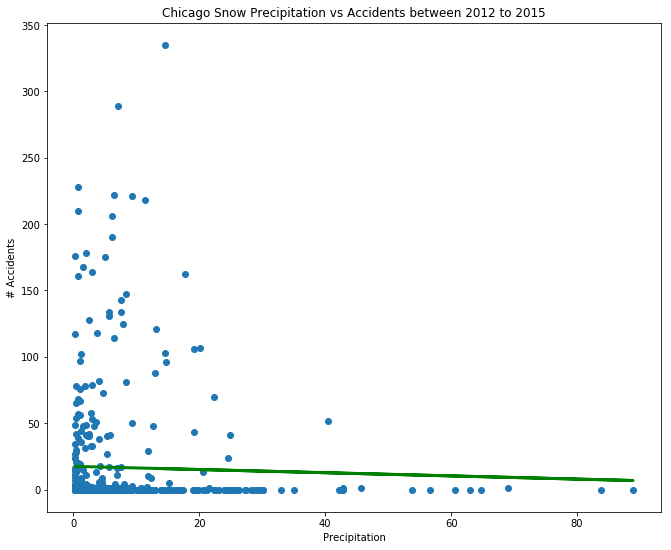

In [0]:
def chi_scatter_rain_only():
    data = pd.read_csv("chi_2012-2015_data.csv")
    #only look at days with precipitation
    data = data.loc[data['precipitation'] > 0]
    plt.figure(figsize=(11,9))
    
    X = pd.DataFrame(data['precipitation'])
    Y = pd.DataFrame(data['num_accidents_rain'])
    
    model = LinearRegression()
    model.fit(X, Y)
    line = model.predict(X)

    print 'Coefficient: ', model.coef_
    print 'Intercept: ', model.intercept_

    plt.scatter(data['precipitation'], data['num_accidents_rain'])
    plt.plot(data['precipitation'], line, color='green', linewidth=3)
    plt.title('Chicago Rain Precipitation vs Accidents between 2012 to 2015')
    plt.xlabel('Precipitation')
    plt.ylabel('# Accidents')
    plt.show()

def chi_scatter_snow_only():
    data = pd.read_csv("chi_2012-2015_data.csv")
    #only look at days with precipitation
    data = data.loc[data['precipitation'] > 0]
    plt.figure(figsize=(11,9))
    
    X = pd.DataFrame(data['precipitation'])
    Y = pd.DataFrame(data['num_accidents_snow'])
    
    model = LinearRegression()
    model.fit(X, Y)
    line = model.predict(X)

    print 'Coefficient: ', model.coef_
    print 'Intercept: ', model.intercept_

    plt.scatter(data['precipitation'], data['num_accidents_snow'])
    plt.plot(data['precipitation'], line, color='green', linewidth=3)
    plt.title('Chicago Snow Precipitation vs Accidents between 2012 to 2015')
    plt.xlabel('Precipitation')
    plt.ylabel('# Accidents')
    plt.show()

    
chi_scatter_rain_only()
chi_scatter_snow_only()

#### Bar graphs for chicago

shows average number or accidents that have occurred with and without precipitation

second function shows average number of accidents that have occurred with not precipitation, rain, or snow


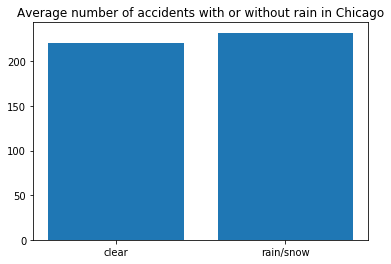

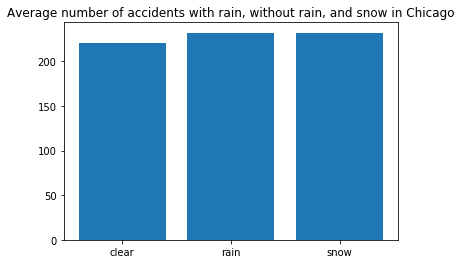

In [0]:
def avg_chi():
    data = pd.read_csv("chi_2012-2015_data.csv")
    no_rain = data.loc[data['precipitation'] == 0]
    rain = data.loc[data['precipitation'] > 0]

    num_no_rain = len(no_rain.index)
    num_rain = len(rain.index)

    accidents_no_rain = no_rain.sum(axis=0)['num_accidents']
    accidents_rain = rain.sum(axis=0)['num_accidents']

    avg_no_rain = accidents_no_rain / num_no_rain
    avg_rain = accidents_rain / num_rain
    plt.title('Average number of accidents with or without rain in Chicago')
    plt.bar(['clear', 'rain/snow'], [avg_no_rain, avg_rain])
    plt.show()

def avg_chi_detailed():
    data = pd.read_csv("chi_2012-2015_data.csv")
    no_rain = data.loc[data['precipitation'] == 0]
    rain = data[(data['precipitation'] > 0) & (data['avg_temp'] > 0)]
    snow = data[(data['precipitation'] > 0) & (data['avg_temp'] <= 0)]

    num_no_rain = len(no_rain.index)
    num_rain = len(rain.index)
    num_snow = len(snow.index)

    accidents_no_rain = no_rain.sum(axis=0)['num_accidents']
    accidents_rain = rain.sum(axis=0)['num_accidents']
    accidents_snow = snow.sum(axis=0)['num_accidents']


    avg_no_rain = accidents_no_rain / num_no_rain
    avg_rain = accidents_rain / num_rain
    avg_snow = accidents_snow / num_snow
    plt.title('Average number of accidents with rain, without rain, and snow in Chicago')
    plt.bar(['clear', 'rain', 'snow'], [avg_no_rain, avg_rain, avg_snow])
    plt.show()
    
    
    
avg_chi()
avg_chi_detailed()